# Evaluation of vaccination bonus in Slovak Republic

This Jupiter notebook is used for downloading, pre-processing, storing data, sending any dataset to any email. In the second part of the notebook we are interested in evaluation of the vaccination bonus introduced by Slovak Government. 

The incentive program was introduced in late November 2021, when the Delta wave of CoViD-19 was at its peak and the Omicron variant was first observed in the South Africa. These circumstances have forced policy makers to launch a system of vaccination incentives. The scheme was presented as a tool to increase the vaccination rate in the most vulnerable groups, people aged 60 and older. Slovakia is the third worst country in the EEA in terms of vaccination in these age groups.

The incentive consists of several parts, a 200€ cash payment was to be sent to anyone who was not vaccinated before 25.11.2021 and after that date underwent one of the available vaccinations, but the offer was limited until the end of January 2022-56th week of vaccination(will be important later). In the case of one dose vaccine, the recipient is obliged to be re-vaccinated by 15.3.2021. Since we only focus on this part of the scheme, we will not describe the other parts. More details can be found here: https://www.mfsr.sk/sk/media/tlacove-spravy/zakladne-info-k-financnej-pomoci-seniorom-60-za-ockovanie.html

To measure the impact of the policy on first dose vaccination coverage, we were using several datasets, which are open to everyone. Weekly vaccination by age group is key and is obtained from Github IZA (Institute of Health Analysis). The dataset is updated daily.We decided to employ demographic data from the Statistical Office of the Slovak Republic, the data are aggregated in Excel, which will be attached. It is not mandatory for analysis, but useful in describing the context of the situation at the time of the bonus announcement, we also use datasets containing admissions to the hospitals and a positive PCR test aggregated by weeks. If necessary, it is possible to download hospital admissions or the number of patients in hospitals in a given week using the NCZI API, proof of the concept is given at the end of the notebook. 

As mentioned above, the first part focuses mainly on the pre-processing of data and their storage in a suitable form. To achieve this, we used the Pandas and NumPy libraries. Several data files are created that are ready to further use in the form of .xlsx.

In the analytical part, we were trying to forecast the counterfactual of the vaccination rates without the bonus. To do so we are employing the Bass model, which is mainly used to predict the market shares of various newly introduced products, as well as mature ones. The model presents a rationale of how current adopters and potential adopters of a new product interact and it is based on simple differential equation. The basic premise of the model is that adopters can be classified as innovators or as imitators and the speed and timing of adoption depend on their degree of innovativeness and the degree of imitation among adopters. We decided not to use well known time series models such as ARIMA, or similar, to forecast such a "world" mainly due to the fact that these models do not estimate the potential "market" size. In order to the estimate parameters of the model we employed OLS estimate. 
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8457353/)
(https://srdas.github.io/MLBook/productForecastingBassModel.html#main-ideas)
(http://www.bassbasement.org/BassModel/Default.aspx)
(https://en.wikipedia.org/wiki/Bass_diffusion_model)

Undoubtedly, the biggest challenge of the project was to distinguish between the natural increase from the increase in vaccination coverage caused by the incentives. This "natural" increase mainly comes from two different currents, some people feared severe case or death, some were sick of pandemic restrictions such as OPT regime (vaccinated, recovered, tested) in the workplace, pubs, public places etc. To solve it, we have  chosen a difference in difference approach, not analytically, only making strong assumptions based on this idea. We constructed the counterfactual scenario on groups that were not entitled to the bonus, the estimate was made from the same week as for the eligible groups, ie. incentive announcement. This approach allows us to monitor and compare natural and measure-induced increases in vaccination coverage in all groups. Simply put, the difference in increased coverage between groups that are eligible for the bonus and those that are not gives us an estimate of the impact of the measure. As the supply of vaccines initially had some logistical constraints, so not everyone in the group had access to the vaccine and the delay could lead to a skew in the forecast, we decided not to group the age groups under 60 and over 60. To each group age we found the approximatelly week, when the vaccination began and we used data from the beginning till week 47 when the bonus was annouced. Since there was not the same start line for each age group, we decided to transform the difference between counterfactual forecast and observed data as a share of population eligible to the vaccination, thus not vaccinated till week 47.

## Results and Discussion
### Results:
The average increase in vaccination was around 4.4 p.p. in the 60+ age groups, representing almost 15% of the eligible population for the first dose. In populations under the age of 60, the average increase was 4.27 p.p. which represents only 9.3% of the population eligible for the first dose of vaccination. We performed a T-test and at the 5% level of statistical significance we must state that the increase in vaccination was higher in the 60+ population. Before starting the t-test, we also confirmed the equality of variances using the F-test.

If we assume that the unobserved effect of incidence and the restrictive measures is the same for every age group, then the difference between them should represent the effect of financial incentive (Difference in difference approach). Following the idea we obtained that more than 39.4% of the observed increase was caused by the effect of the financial incentive. As between w47-2021 and w4-2022, we recorded approximately 33176 of the first doses administered in the age groups over 60 years. We can conclude that the incentive represent more than 15 000 people aged 60 or above who would not be vaccinated without the bonus. 

<br>**Note:** The total number of administered doses in weeks may vary. The impact of such data imperfections can be reflected in the difference between the presented result and script result in the order of several tens. 

### Discussion

The result should be unconfirmed estimate of the effect, as there may be hidden bias in the data (for example: **vaccination capacity**,  60+ were entitled to revaccination at the time and preferred to younger adults, demand could potentially exceed vaccine center capacity across the country, ie younger adults did not receive term of the vaccination "in time".
The news of a "friendlier" omicron variant has made headlines over time, which may lead to a decline in interest in vaccinations, especially among younger adults. To address such an issue, a synthetic control group should be used to confirm or refute the effect obtained. 

In [1]:
#This part of the code is used for import libraries which we are using later
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import xlsxwriter
import matplotlib.pyplot as plt
#from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf 
import math

In [2]:
import smtplib
from email.message import EmailMessage


In [3]:
# function nacitaj data is used for declaring main dataset 
def nacitaj_data():
    global df #dataframe ockovanie
    df= pd.read_csv("https://raw.githubusercontent.com/Institut-Zdravotnych-Analyz/covid19-data/main/Vaccination/OpenData_Slovakia_Vaccination_AgeGroup_District_comma.csv")
    #df.to_excel('pokus.xlsx')
    global pop #populacia
    #excel="D:\Datapython\pop.xlsx"
    pop_list= {'AgeGroup':['80+','75-79','70-74','65-69','60-64','55-59','50-54','45-49','40-44','35-39','30-34','25-29','20-24','60+','60-'],'populacia':[189121,160295,247632,334976,353682,356041,345716,414217,453932,433922,403000,350572,286207,1285706,3043607]} 
    pop=pd.DataFrame(pop_list)
    # pop= pd.read_excel(excel, 'Sheet1') 
   # pop=pop[['AgeGroup','populacia']]
   # global demo #demografia
   # demo= pd.read_excel (excel, 'Demografia')
nacitaj_data()

In [4]:
# This part of the code represents the function which are used for send mails 
# with dataset in .xlsx for further use for anyone who is not familiar with pandas 
# and needs to do some preprocesing repeatedly

SENDER_EMAIL = "posielanadata@gmail.com"
APP_PASSWORD = "pokuS123"
contents=""

def content():
    now = datetime.now()
    date_time = now.strftime("%m.%d.%Y, %H:%M:%S")
    global contents
    contents="Export z : "+date_time

    
#funkcia na posielanie mailu. 

def send_mail_with_excel(recipient_email, subject, excel_file):
    msg = EmailMessage()
    msg['Subject'] = subject 
    msg['From'] = SENDER_EMAIL
    msg['To'] = recipient_email
    content()
    msg.set_content(contents)

    with open(excel_file, 'rb') as f:
        file_data = f.read()
    msg.add_attachment(file_data, maintype="application", subtype="xlsx", filename=excel_file)

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(SENDER_EMAIL, APP_PASSWORD)
        smtp.send_message(msg)


#send_mail_with_excel("pet.kravec@gmail.com","pokus","pokus.xlsx" )

In [5]:
class Data:
    def __init__(self,allowLog=True):
        global df #dataframe Vaccination Slovak data
        df= pd.read_csv("https://raw.githubusercontent.com/Institut-Zdravotnych-Analyz/covid19-data/main/Vaccination/OpenData_Slovakia_Vaccination_AgeGroup_District_comma.csv")
        global pop #populacia
        excel="D:\Datapython\pop.xlsx"
        pop= pd.read_excel(excel, 'Sheet1')
        pop=pop[['AgeGroup','populacia']]
        global demo #demografia
        demo= pd.read_excel (excel, 'Demografia')
        

In [6]:
def prehlad_ockovanie_sumar():
    nacitaj_data() # to initial dataset
# declaring the order of doses. List allows us to append another dose if neccesary. 

    doses = ["1","2","3"] 

    for x in doses: #for cycle overage of vaccine uptake in age groups in respect with doses
        #selecting by age groub and by dose and agregating 
        select=df[(( (df.dose==x)) & (df.vaccine!='') )].groupby(['AgeGroup']) [['doses_administered',]].sum() 
        
        #sorting values
        select=select.sort_values(by='AgeGroup', ascending=False)  
   
        
        if x=="1":
            global result
            #merging selected dataframe with population dataframe 
            result = pd.merge(select, pop, how="left",on=["AgeGroup"] ) 
            #string linking 
            concat=x+".dose_administered"
            #column renaming 
            result= result.rename(columns={"doses_administered":concat})
           
            #same as above 
        else:
            result = pd.merge(result, select, how="left",on=["AgeGroup"] )
            concat=x+".dose_administered"
            result= result.rename(columns={"doses_administered":concat})
    #selecting one shot vaccine, J&J       
    select=df[(( (df.dose=='1')) & (df.vaccine=='JANSSEN')& (df.AgeGroup!='5-9')& (df.AgeGroup!='18-19')& (df.AgeGroup!='15-17')& (df.AgeGroup!='10-14'))].groupby(['AgeGroup']) [['doses_administered',]].sum()
    select=select.sort_values(by='AgeGroup', ascending=False)
    result= pd.merge(result, select, how="left",on=["AgeGroup"] )
    result= result.rename(columns={"doses_administered":"J&J"})
            
    result["zaockovanost"]= result["1.dose_administered"] / result["populacia"] #vac uptake at least one dose

    result["zaockovanost 3. davkou"]= result["3.dose_administered"] / result["populacia"] #booster  uptake
    
    result["preockovanost 3. davkou"]= result["3.dose_administered"] / result["1.dose_administered"] #booster uptake in population which has at least one dose
     
    lists=["zaockovanost","zaockovanost 3. davkou", "preockovanost 3. davkou"]
    for x in lists:
        result[x] = result[x].astype(float).map("{:.3%}".format) #formating columns as % with 3 decimal numbers 
    
    #rearanging dataframe 
    result=result[['AgeGroup','populacia','1.dose_administered','J&J','2.dose_administered','3.dose_administered','zaockovanost','zaockovanost 3. davkou', 'preockovanost 3. davkou']]
    
    #saving results in excel 
    result.to_excel('pokus_skupiny2.xlsx')
    #send_mail_with_excel("pet.kravec@gmail.com","pokus","pokus_skupiny2.xlsx" )
    print('hotovo prehlad_ockovanie_sumar')


In [7]:
#this function is used for make overview of vaccination uptake in week in each of requested age group. 
#dataframe for each dose is copied into the separate sheet in excel. 
#the result of the function is, in addition to the .xlsx file, also a list of dataframes, each dataframe is for each batch 

def Ockovanie_Tyzdenne():
    global list_df
    list_df = {}
    
    #obtaining distinct age group from original dataframe in descending form, will be used in for cycle later.
    result= df.loc[((df.AgeGroup!='5-9')&(df.AgeGroup!='nan')& (df.AgeGroup!='15-17')& (df.AgeGroup!='10-14')),["AgeGroup"]].drop_duplicates().sort_values(by='AgeGroup', ascending=False)
    global agegroups
    agegroups=result["AgeGroup"].tolist() #selected df to list 
    doses = ["1","2","3"]
    
    with pd.ExcelWriter('output_SR.xlsx') as writer:   #open excel to write
        
        for x in doses: #for each dose
            
            result=df[['week']].drop_duplicates() # the number of the week as the first column in which we can merge selections made later 

            for y in agegroups:
                # selecting, merging, renaming, sorting 
                select=df[( (df.dose==x) & (df.vaccine!='') & (df.AgeGroup==y)) ].groupby(['week']) [['doses_administered',]].sum()
                result = pd.merge(result, select, how="left",on=['week'])
                result= result.rename(columns={"doses_administered":y})
                result=result.sort_values(by=['week'])

            list_df[int(x)]=result   
            
            if int(x)==3:
                
                tyzden=int(date.today().strftime("%V"))+19   #Booster shots were available in October, so we're skipping the first few weeks  
                list_df[int(x)]=list_df[int(x)].tail(tyzden)
                list_df[int(x)].to_excel(writer, sheet_name=x,index='none')

            else:
                list_df[int(x)].to_excel(writer, sheet_name=x,index='none') 
        
    print('hotovo Ockovanie_Tyzdenne')

    
 #this function is using list of dataframes, which were made in function Ockovanie_Tyzdenne() to further processing for now is used only for the first doses since we are interested mainly in those. By little changes we are able to adjust script for same structure for each dose 
def Ockovanie_Tyzdenne_zostatok():
    global result1
    result1=pd.DataFrame()
    for x in range(1,4):
        
        result=list_df[x]
        
        for y in agegroups:
            t="zvyšok "+str(y)
            try:
                popu=pop.loc[pop.AgeGroup==y,'populacia'].values[0]
            except:
                print()
            else:    
                if x==1:
                    result[t] = popu - result[y].cumsum() # how many people are left unvaccinated   
                    tt='podiel nezaockova '+str(y)  
                    result[tt] = result[y]/result[t].shift(+1) # % of vaccinated people in given week-t from people which were not vaccinated week before - (t-1)
                    ttt='cumulative '+str(y)
                    result1[ttt] =result[y].cumsum() #cumulative sum of vaccinated people
                    result.to_excel('output_extended.xlsx') # result to excel
                #elif x==2:
                     #dopracovat result[t] = list_df[1] [y].cumsum() - result[y].cumsum()
               
        
        list_df[x]=result # rewrite the original dataframe (x-th dataframe in list)
        #result.to_excel('output_extended.xlsx')
 


In [8]:
%%time
Ockovanie_Tyzdenne()
prehlad_ockovanie_sumar()
Ockovanie_Tyzdenne_zostatok()


hotovo Ockovanie_Tyzdenne
hotovo prehlad_ockovanie_sumar






Wall time: 12.4 s


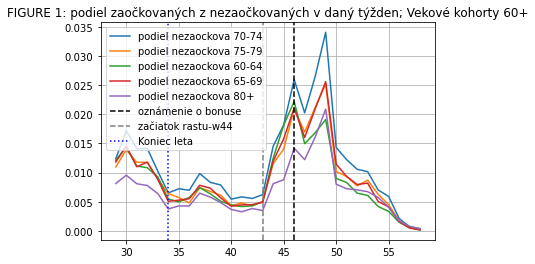

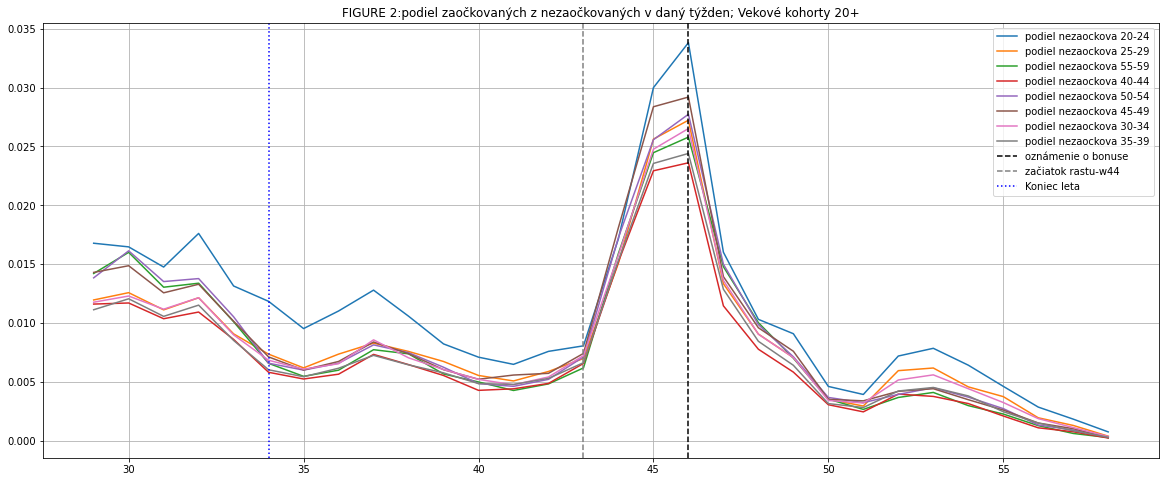

In [9]:
#following the function Ockovanie_Tyzdenne_zostatok() ploting the % of vaccinated people in given week-t from people which were not vaccinated week before - (t-1)

stlpce={}
df1=list_df[1] [{'podiel nezaockova 80+','podiel nezaockova 75-79','podiel nezaockova 70-74','podiel nezaockova 65-69','podiel nezaockova 60-64'}]#.tail(25)
stlpce=df1.columns.values.tolist()
df1=df1.tail(30)


fig, ax = plt.subplots()
plt.title('FIGURE 1: podiel zaočkovaných z nezaočkovaných v daný týžden; Vekové kohorty 60+')

for x in stlpce:
    ax.plot( df1 [x],label = x)
plt.axvline(x = 46, color = 'black', linestyle='--',label = 'oznámenie o bonuse')
plt.axvline(x = 43, color = 'grey', linestyle='--',label = 'začiatok rastu-w44')
plt.axvline(x = 34, color = 'blue', linestyle=':',label = 'Koniec leta')
ax.grid(True)
plt.legend()
plt.rcParams["figure.figsize"] = (20,8)
plt.yscale("linear")
plt.show()




df2=list_df[1] [{'podiel nezaockova 50-54','podiel nezaockova 55-59','podiel nezaockova 40-44','podiel nezaockova 45-49','podiel nezaockova 35-39','podiel nezaockova 30-34','podiel nezaockova 25-29','podiel nezaockova 20-24'}]#.tail(25)
stlpce=df2.columns.values.tolist()
df2=df2.tail(30)

fig, ax = plt.subplots()
plt.title('FIGURE 2:podiel zaočkovaných z nezaočkovaných v daný týžden; Vekové kohorty 20+')
for x in stlpce:
    ax.plot( df2 [x],label = x)
ax.grid(True)
plt.legend(df2.columns,)
plt.axvline(x = 46, color = 'black', linestyle='--',label = 'oznámenie o bonuse')
plt.axvline(x = 43, color = 'grey', linestyle='--',label = 'začiatok rastu-w44')
plt.axvline(x = 34, color = 'blue', linestyle=':',label = 'Koniec leta')
plt.legend()
plt.rcParams["figure.figsize"] = (20,8)
plt.yscale("linear")
plt.show()


In [13]:
#processing dataset about pacients in hospitals
df3=pd.DataFrame()
url='https://raw.githubusercontent.com/Institut-Zdravotnych-Analyz/covid19-data/main/Hospitals/OpenData_Slovakia_Covid_Hospital_AdmissionDischarge_Regions.csv'
df3 = pd.read_csv(url,sep=';') #github csv to the datafrem 
df3.drop('Unnamed: 0',inplace=True,axis=1) #dropping unnamed column
df3['formatted_date'] = pd.to_datetime(df3['Date']) #making sure that date in csv is properly formated for next procesing
df3['week'] = df3.formatted_date.apply(lambda x: x.weekofyear) #week of the year to match(or join ) the vaccination data on the graph
df3['year']= df3['formatted_date'].dt.year #year since vac. begin in 2020
df3=df3[(df3["year"]!=2020)] # dropping 2020 data away the dataset of vacc begins as first week of 2021.
df3.loc[(df3['year'] == 2022)&(df3['week']<52), 'week'] = df3['week']+52 # to index data as week of the vaccination ie. first week of 2021 is 1st week, but 1st week 2022 is the 53th of vaccination in slovakia
df3.loc[(df3['year'] == 2021)&(df3['week']==53), 'week'] = 1 # agregatting the data from w53-2021 (actually w53-2020)to the w1 2021
df3=df3.groupby(['week']) [['Admissions']].sum() #admissions by week
df3=df3.reset_index() #reseting index
df3=df3.drop('week', axis=1) # preparation to the ploting on the graphs


In [12]:
#processing dataset about positive PCR tests
    df2=pd.DataFrame()

    url="https://raw.githubusercontent.com/Institut-Zdravotnych-Analyz/covid19-data/main/PCR_Tests/OpenData_Slovakia_Covid_PCRTests_District.csv"
    df2= pd.read_csv(url,sep=';')

    df2['formatted_date'] = pd.to_datetime(df2['Date'])
    df2=df2.drop('Date',axis=1)
    #df1['day_of_year'] = df1.formatted_date.apply(lambda x: x.dayofyear)
    df2['week'] = df2.formatted_date.apply(lambda x: x.weekofyear)
    df2['year']= df2['formatted_date'].dt.year

    df2=df2[(df2["year"]!=2020)]
    df2.loc[(df2['year'] == 2022)&(df2['week']<52), 'week'] = df2['week']+52
    df2.loc[(df2['year'] == 2021)&(df2['week']==53), 'week'] = 1
    df2=df2.groupby(['week']) [['PCR_Pos']].sum()
    df2=df2.reset_index()
    df2=df2.drop('week', axis=1)
#the same principle as above.

IndentationError: unexpected indent (<ipython-input-12-1f5181c4099b>, line 2)